In [1]:
#SECTION1
# IMPORT MODULES
import pandas as pd
import os 
import sys 
from glob import glob

# SETTING UP PYTHON PATH
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# ENABLING AND CONFIGURING AUTORELOAD
%load_ext autoreload
%autoreload 2


In [2]:
#SECTION2
# PACKAGE INSTALLATION COMMANDS
!pip install trimesh
!pip install geopandas
!pip install opencv-python

# PYTHON IMPORTS
# Files in same folder as Jupyter Notebook
from preprocess import *
from shapely_geoms import*
from stl_to_shapely import *
from visualize import *

import cv2

In [3]:
#SECTION3
# DEFINE BASE DIRECTORY
aperiod ='/Users/irvingrc/Documents/°ASU Ph.D/3DX Research Group/Aperiodic Project/Node_Nucleus_Quantification/'

# DEFINE STL FILES DIRECTORY
stldir = aperiod + 'specimens/'
all_stls = glob(stldir + '*.stl')
[print(stl) for stl in all_stls]
pass

/Users/irvingrc/Documents/°ASU Ph.D/3DX Research Group/Aperiodic Project/Node_Nucleus_Quantification/specimens\19-wall0.5mm_sv0_sn0.0_type-h-v2.stl
/Users/irvingrc/Documents/°ASU Ph.D/3DX Research Group/Aperiodic Project/Node_Nucleus_Quantification/specimens\20-wall0.5mm_sv0_sn0.05_type-h-v2.stl
/Users/irvingrc/Documents/°ASU Ph.D/3DX Research Group/Aperiodic Project/Node_Nucleus_Quantification/specimens\21-wall0.5mm_sv0_sn0.1_type-h-v2.stl
/Users/irvingrc/Documents/°ASU Ph.D/3DX Research Group/Aperiodic Project/Node_Nucleus_Quantification/specimens\22-wall0.5mm_sv0_sn0.15_type-h-v2.stl
/Users/irvingrc/Documents/°ASU Ph.D/3DX Research Group/Aperiodic Project/Node_Nucleus_Quantification/specimens\23-wall0.5mm_sv0_sn0.2_type-h-v2.stl
/Users/irvingrc/Documents/°ASU Ph.D/3DX Research Group/Aperiodic Project/Node_Nucleus_Quantification/specimens\24-wall0.5mm_sv0.05_sn0_type-h-v2.stl
/Users/irvingrc/Documents/°ASU Ph.D/3DX Research Group/Aperiodic Project/Node_Nucleus_Quantification/specimen

In [4]:
#SECTION4
# SELECT STL FOR ANALYSIS --> 0-8
stl = all_stls[0]        
name = (stl.split('/')[-1])[:-4]
print(name) # Shows specimen name --> Verify

# Initialize Storage Path 
if not os.path.exists(name):
    os.makedirs(name)

global_traits = {}
poly = honeycomb_union(stl)
simple = poly.simplify(1) # Douglas-Peucker 

specimens\19-wall0.5mm_sv0_sn0.0_type-h-v2


Shapely Docs: https://shapely.readthedocs.io/en/stable/index.html
Geopandas Plotting:https://geopandas.org/en/latest/docs/user_guide/mapping.html 

In [5]:
# SECTION5
# LIBRARIES AND SETUP
import geopandas as gpd
import shapely
'''
#BEFORE
#FUNCTION DEFINITION
def sides(poly):
    return shapely.get_num_coordinates(poly.simplify(0.5)) -1

#GEOMETRIC DATA PROCESSING

#Cell Characteristics 
glr = gpd.GeoSeries(poly.interiors)
gp = glr.map(shapely.Polygon)
interior_gdf = gpd.GeoDataFrame({'geometry': gp})

#CELL COUNTING AND FEATURE EXTRACTION
global_traits['cell_count'] = len(interior_gdf) #Count number of cells

#Quantify cells 
interior_gdf['sides'] = gp.map(sides) #Map the side counting function to the polygon 
interior_gdf['area'] = interior_gdf.geometry.area

#SPATIAL METRICS CALCULATION
#Max and min xy values
interior_gdf = interior_gdf.join(interior_gdf.geometry.bounds)
interior_gdf['xanisotropy'] = (interior_gdf.maxy - interior_gdf.miny)/(interior_gdf.maxx - interior_gdf.minx)
interior_gdf['yanisotropy'] = (interior_gdf.maxy - interior_gdf.miny)/(interior_gdf.maxx - interior_gdf.minx)
'''
# FUNCTION DEFINITION
def sides(poly):
    """Calculate the number of sides of a simplified polygon."""
    simplified_poly = poly.simplify(0.5)
    if simplified_poly.is_empty:
        return 0  # Return 0 for empty simplified polygons
    return len(simplified_poly.exterior.coords) - 1

# GEOMETRIC DATA PROCESSING
# Assume 'poly' is a predefined complex polygon, possibly loaded or defined earlier
# Cell Characteristics
if hasattr(poly, 'interiors'):
    glr = gpd.GeoSeries([shapely.geometry.Polygon(interior) for interior in poly.interiors])
    interior_gdf = gpd.GeoDataFrame({'geometry': glr})
else:
    interior_gdf = gpd.GeoDataFrame(columns=['geometry'])  # Empty DataFrame if no interiors

# CELL COUNTING AND FEATURE EXTRACTION
global_traits = {}
global_traits['cell_count'] = len(interior_gdf)  # Count number of cells

# Quantify cells
interior_gdf['sides'] = interior_gdf['geometry'].map(sides)  # Map the side counting function to each polygon
interior_gdf['area'] = interior_gdf['geometry'].area  # Calculate the area of each cell

# SPATIAL METRICS CALCULATION
# Max and min xy values, added robustness by checking for empty DataFrame
if not interior_gdf.empty:
    interior_gdf = interior_gdf.join(interior_gdf['geometry'].bounds)
    interior_gdf['length_x'] = interior_gdf['maxx'] - interior_gdf['minx']
    interior_gdf['length_y'] = interior_gdf['maxy'] - interior_gdf['miny']

    # Calculate Shape-Anisotropy Ratio R1 and R2
    interior_gdf['Shape-Anisotropy R1'] = interior_gdf['length_x'] / interior_gdf['length_y'].replace(0, np.nan)  # Avoid division by zero
    interior_gdf['Shape-Anisotropy R2'] = interior_gdf['length_y'] / interior_gdf['length_x'].replace(0, np.nan)  # Avoid division by zero
else:
    print("No interior geometries to analyze.")



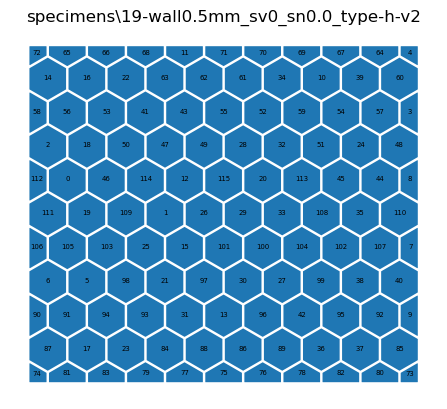

In [6]:
#SECTION6
# Create a labelled cell plot 
interior_gdf.plot()
plt.title(f'{name}')
plt.axis('off')

for idx, row in interior_gdf.iterrows():
    centroid = row.geometry.centroid.xy
    plt.annotate(str(idx), xy=[p[0] for p in centroid],
                 horizontalalignment='center', size=5)
    
plt.savefig(f'{name}/labelled_cells.png', dpi=200, bbox_inches='tight')

# Save cell properties (matching the labelled image!!!)
(interior_gdf.iloc[:, 1:]).to_excel(f"{name}/cell_properties.xlsx",)

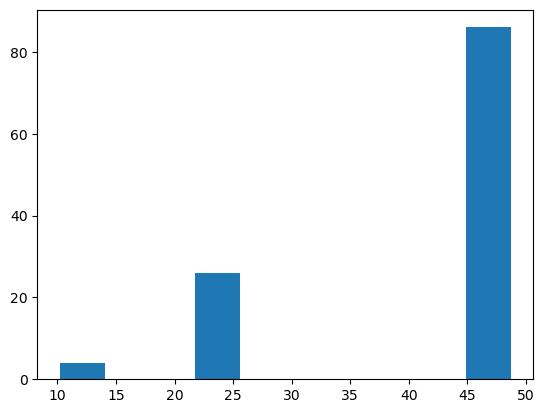

In [7]:
#SECTION7
interior_gdf
plt.hist(interior_gdf.area)
plt.savefig(f'{name}/histogram.png', dpi=200, bbox_inches='tight')
(interior_gdf.iloc[:, 1:]).to_excel(f"{name}/histogram.xlsx",)

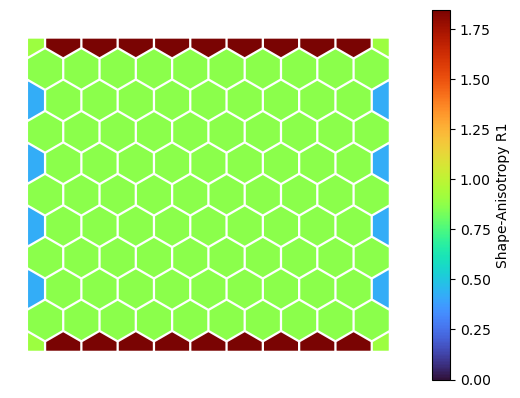

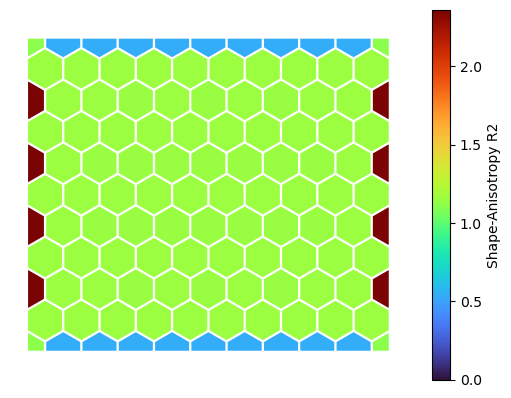

Index(['geometry', 'sides', 'area', 'minx', 'miny', 'maxx', 'maxy', 'length_x',
       'length_y', 'Shape-Anisotropy R1', 'Shape-Anisotropy R2'],
      dtype='object')


In [8]:
#SECTION8
import matplotlib.pyplot as plt

'''
#BEFORE
# Create a feature plot 
print(interior_gdf.columns)
chara, unit = 'anisotropy', 'mm2'
ax = interior_gdf.plot(chara, cmap='coolwarm', legend=True,
                       legend_kwds={"label": f'{chara} ({unit})', "orientation": "vertical"})
plt.title(f'{name}')
plt.axis('off')
# Saveplot goes here
plt.savefig(f'{name}/anisotropy.png', dpi=200, bbox_inches='tight')
print(interior_gdf.columns)'''

# Assuming 'interior_gdf' has been previously defined and contains 'Shape-Anisotropy Ratio R1' and 'Shape-Anisotropy Ratio R2'
# Function to create plots based on 'Shape-Anisotropy Ratios'
def plot_anisotropy_ratios(gdf, column_name, file_suffix, title):
    if column_name in gdf.columns:
        ax = gdf.plot(column=column_name, cmap='turbo', legend=True,
                      legend_kwds={"label": f"{title}", "orientation": "vertical"},
                      vmin=0, vmax=gdf[column_name].max())  # Start scale at 0 and use max from data
        plt.axis('off')

        # Save plot to the directory named after the STL file
        plt.savefig(f'{name}/{file_suffix}.png', dpi=200, bbox_inches='tight')

        # Show plot in notebook or script if necessary (optional, depending on your environment)
        plt.show()
    else:
        print(f"{title} column is not available in the DataFrame.")

# Plot Shape-Anisotropy Ratio R1
plot_anisotropy_ratios(interior_gdf, 'Shape-Anisotropy R1', 'shape_anisotropy_r1', 'Shape-Anisotropy R1')

# Plot Shape-Anisotropy Ratio R2
plot_anisotropy_ratios(interior_gdf, 'Shape-Anisotropy R2', 'shape_anisotropy_r2', 'Shape-Anisotropy R2')

# Print DataFrame columns to confirm
print(interior_gdf.columns)

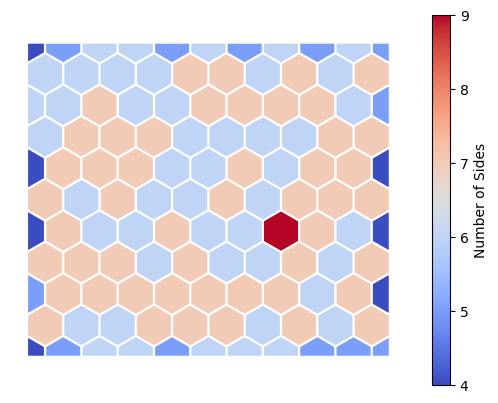

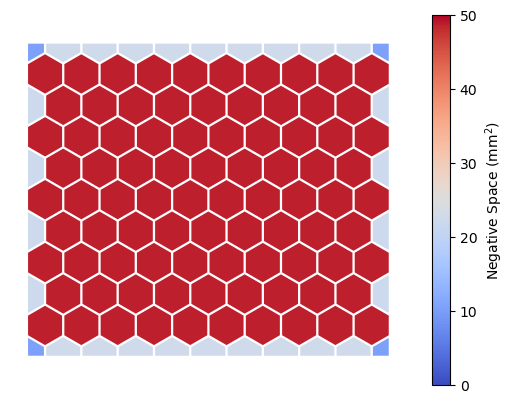

In [9]:
#SECTION9
# Create a feature plot 
'''
#BEFORE
chara= 'sides'
#chara= 'area'
ax = interior_gdf.plot(chara, cmap='coolwarm', legend=True,
                       #legend_kwds={"label": f'{chara}', "orientation": "vertical"})
                       legend_kwds={"label": "", "orientation": "vertical"}) #Modify Legend
#plt.title(f'{name}')
plt.axis('off')

# Saveplot goes here
plt.savefig(f'{name}/sides.png', dpi=200, bbox_inches='tight')
plt.savefig(f'{name}/area.png', dpi=200, bbox_inches='tight')
'''
# IMPORT MODULES
import matplotlib.pyplot as plt
import os

# Ensure the notebook displays plots inline
%matplotlib inline

# Define the directory for saving plots, ensure it's using the global variable 'name'
if 'name' not in globals():
    print("Error: 'name' variable is not set. Please set 'name' with the directory or specimen name.")
else:
    directory = f'{name}'
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Plot for the number of sides
    fig, ax = plt.subplots()
    interior_gdf.plot(column='sides', cmap='coolwarm', legend=True,
                      legend_kwds={"label": "Number of Sides", "orientation": "vertical"}, ax=ax)
    ax.axis('off')
    plt.savefig(f'{name}/sides.png', dpi=200, bbox_inches='tight')
    plt.show()
    plt.close(fig)

    # Plot for the area with customized label using TeX markup for superscript
    fig, ax = plt.subplots()
    interior_gdf.plot(column='area', cmap='coolwarm', legend=True,
                      legend_kwds={"label": "Negative Space (mm$^2$)", "orientation": "vertical"},
                      ax=ax, vmin=0, vmax=50)  # Set the color scale from 0 to 50
    ax.axis('off')
    plt.savefig(f'{name}/area.png', dpi=200, bbox_inches='tight')
    plt.show()
    plt.close(fig)



In [10]:
#SECTION10
# Rasterize polygon into an image
scaled = shapely.affinity.scale(simple, xfact=100, yfact=100, origin='center')

xmin, ymin, xmax, ymax = scaled.bounds
x = round(xmax - xmin)
y = round(ymax - ymin)

transl = shapely.affinity.translate(scaled, xoff=-xmin, yoff=-ymin)
mask = np.zeros((y,x))

ext = [([round(x), round(y)]) for x, y in zip(*transl.exterior.xy)]
mask = cv2.fillPoly(mask, np.array([ext]).astype(np.int32), color=1)

for interior in transl.interiors:
    int_coords = [([round(x), round(y)]) for x, y in zip(*interior.xy)]
    mask = cv2.fillPoly(mask, np.array([int_coords]).astype(np.int32), color=0)
    
# adds a 0 value border on perimeter
mask = cv2.copyMakeBorder(mask, 1, 1, 1, 1, cv2.BORDER_CONSTANT,value=0)

# Segmentization
node_im, seg_im, skel_im = segmentize(mask)


In [11]:
#SECTION11
skel_im.shape
#cv2.imwrite('test.png', 255*skel_im)

(6980, 8052)

Learn more about Distance Transforms:
https://docs.scipy.org/doc/scipy/tutorial/ndimage.html#distance-transforms 

In [12]:
#SECTION12
# Strut Thickness 
dist_transf, bt, nt = thickness(mask, node_im, seg_im)
dist_skel = dist_transf*seg_im # Skeletonized distance transform (effectively, beam thickness)

Understanding REGIONProps

https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops

In [13]:
#SECTION13
# Strut/ Edge Dimensions
labelled_struts, props = shape_analyze(seg_im, table=True, xprops=['coords', 'centroid'])
strut_props = pd.DataFrame(props)
global_traits['strut_count'] = len(strut_props)

(strut_props.iloc[:, :-3]).to_excel(f'{name}/strut_properties.xlsx')


In [14]:
#SECTION14
strut_props

,label,area,orientation,minor_axis_length,major_axis_length,coords,centroid-0,centroid-1
0,1,797,1.568931,1.019444,920.297205,"[[25, 428], [25, 429], [25, 430], [25, 431], [...",25.469260,825.0
1,2,758,1.515270,1.741700,876.613262,"[[25, 1228], [25, 1229], [25, 1230], [25, 1231...",43.786280,1606.5
2,3,834,-1.564599,17.794231,963.038044,"[[25, 2028], [25, 2029], [25, 2030], [25, 2031...",25.888489,2406.5
3,4,796,1.570796,0.000000,919.140903,"[[25, 2828], [25, 2829], [25, 2830], [25, 2831...",25.000000,3225.5
4,5,795,1.570796,0.000000,917.986202,"[[25, 3629], [25, 3630], [25, 3631], [25, 3632...",25.000000,4026.0
...,...,...,...,...,...,...,...,...
344,345,391,-1.564782,1.185975,451.494599,"[[6952, 7630], [6952, 7898], [6952, 7899], [69...",6952.920716,7825.0
345,346,795,1.570796,0.000000,917.986202,"[[6954, 428], [6954, 429], [6954, 430], [6954,...",6954.000000,825.0
346,347,796,1.570796,0.000000,919.140903,"[[6954, 2828], [6954, 2829], [6954, 2830], [69...",6954.000000,3225.5
347,348,796,1.570796,0.000000,919.140903,"[[6954, 3628], [6954, 3629], [6954, 3630], [69...",6954.000000,4025.5


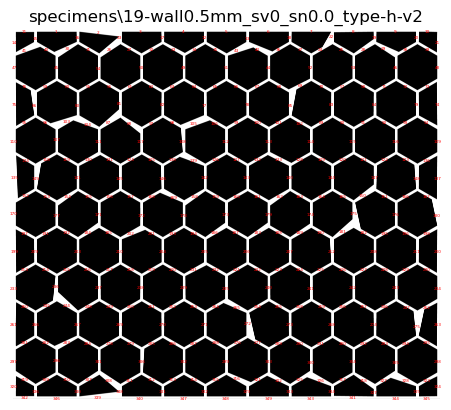

In [15]:
#SECTION15
# Make a labelled Strut Diagram
fig, ax = plt.subplots()
ax.imshow(mask, cmap='gray')

for label, centroid_row in zip(props['label'], zip(props['centroid-1'], props['centroid-0'])):
    ax.text(centroid_row[0], centroid_row[1], str(label), color='red', fontsize=3, ha='center', va='center')

ax.set_title(name)
plt.axis('off')
plt.savefig(f'{name}/labelled_struts', dpi=200, bbox_inches='tight')

(<Axes: >, <matplotlib.image.AxesImage at 0x276aff75f30>)

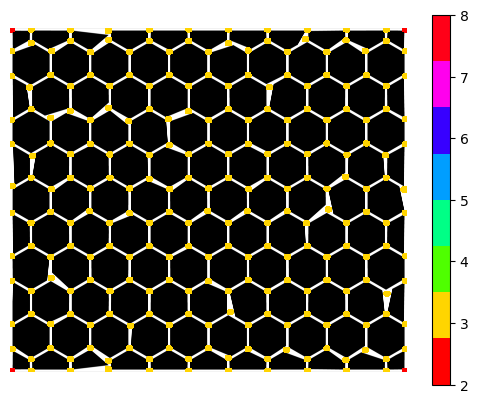

In [16]:
#SECTION16
# Node properties
dil_nodes = expand_nodes(node_im, 80)
node_connectivity, connect_map, c = connectivity(seg_im, node_im, dil_nodes,
                                                 return_map=True)
global_traits['node_count'] = len(c)
global_traits['connectivity'] = c

node_connectivity_map(mask, connect_map)


In [17]:
#SECTION17
global_traits

{'cell_count': 116,
 'strut_count': 349,
 'node_count': 234,
 'connectivity': [2,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  2,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3

In [18]:
#SECTION18
import csv
with open(f'{name}/global_traits.csv', 'w') as f:  # You will need 'wb' mode in Python 2.x
    w = csv.DictWriter(f, global_traits.keys())
    w.writerow(global_traits)


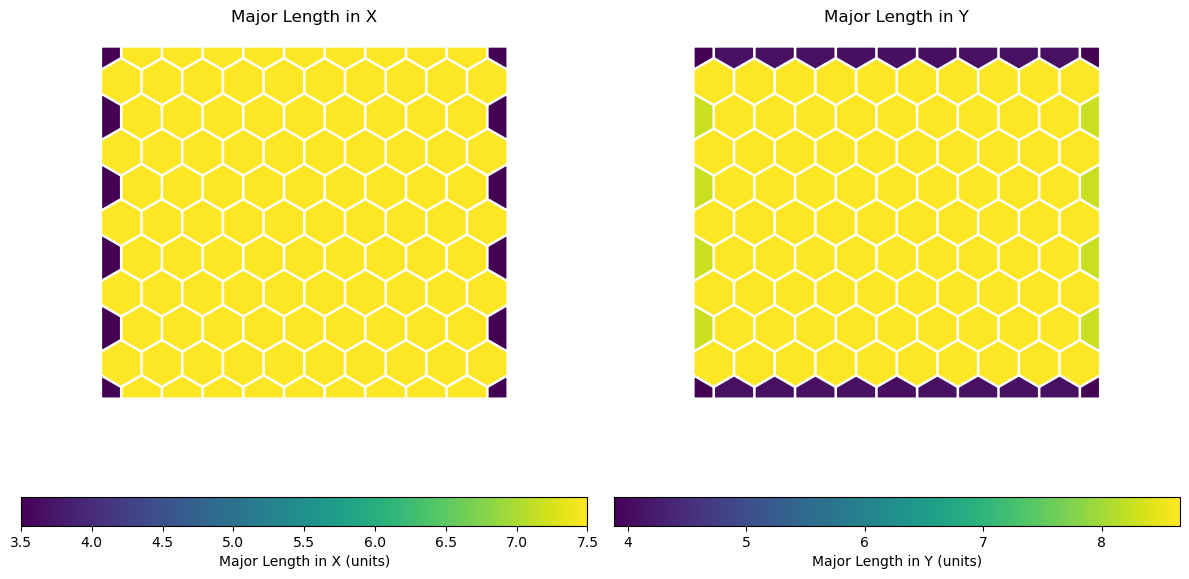

In [19]:
#SECTION19
# IMPORT MODULES
import matplotlib.pyplot as plt
import geopandas as gpd
import os

# Ensure the directory exists
if not os.path.exists(name):
    os.makedirs(name)

# Calculate major lengths in x and y
interior_gdf['length_x'] = interior_gdf['maxx'] - interior_gdf['minx']
interior_gdf['length_y'] = interior_gdf['maxy'] - interior_gdf['miny']

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot major length in x-direction
interior_gdf.plot(column='length_x', cmap='viridis', legend=True,
                  legend_kwds={"label": "Major Length in X (units)", "orientation": "horizontal"},
                  ax=ax1)
ax1.set_title('Major Length in X')
ax1.axis('off')

# Save the x-direction plot
plt_path_x = os.path.join(name, 'major_length_x.png')
plt.savefig(plt_path_x, dpi=300, bbox_inches='tight')

# Plot major length in y-direction
interior_gdf.plot(column='length_y', cmap='viridis', legend=True,
                  legend_kwds={"label": "Major Length in Y (units)", "orientation": "horizontal"},
                  ax=ax2)
ax2.set_title('Major Length in Y')
ax2.axis('off')

# Save the y-direction plot
plt_path_y = os.path.join(name, 'major_length_y.png')
plt.savefig(plt_path_y, dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()
